In [2]:
# The code was removed by Watson Studio for sharing.

# Data Science Capstone - Battle of the Neighborhoods

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Our client has asked us to analyze possible locations for them to open a <b>Thai Food Restaurant</b> in downtown <b>Dallas, TX</b>.<br>
We will identify locations by examining which have the lowest restaurant density, and focus our search around the center of the city.<br><br>

### Priorities
The client placed a very high priority on two attributes:
-    Locations with less than average competition
-    Locations with substantial foot traffic

## Data

Dallas is separated into several "Macro Neighborhoods" which span a very large area--from from downtown with heavy foot traffic to residential neighborhoods with very little foot traffic.<br>
We will start by breaking Dallas into equal geometric sections.<br>
We will then identify which neighborhood each point is in, and the <a href='https://www.walkscore.com/how-it-works/'> WalkScore.com</a> ranking for each point via the WalkScore API.<br>
Finally, we will use data from Foursquare's API to determine which locations are furthest from other Thai Restaurants, other Asian Restaurants in general, and the total number of restaurants in each area.

In [46]:
#!pip install folium
import requests
from bs4 import BeautifulSoup as Soup
import pandas as pd
import numpy as np
import folium
import json
import pickle
import matplotlib.pyplot as plt
from IPython.display import Image

In [29]:
# David Blackman has a repository of GeoJson files on GitHub found here:
    # https://github.com/blackmad/neighborhoods

# Code attempts to pull this data from Git Hub.
# However, I have saved the Dallas GeoJson data as a dictionary to this notebook.
# If the url does not work or the file can't be found, code uses the back up data instead.

try:
    url = 'https://raw.githubusercontent.com/blackmad/neighborhoods/master/dallas.geojson'
    geoj = requests.get(url).json()
    print('GeoJSON Data Pulled Successfully')
except JSONDECODEERROR:
    print('ERROR! - Could not decode JSON file from the given URL.  Using the JSON data saved to this notebook instead.')
    x = json.dumps(GEO_JSON_DICT, separators=(',', ':'))
    geoj = json.loads(x)
except MISSINGSCHEMA:
    x = json.dumps(GEO_JSON_DICT, separators=(',', ':'))
    geoj = json.loads(x)
    print('ERROR! - Could not find the given URL.  Using the JSON data saved to this notebook instead.')

GeoJSON Data Pulled Successfully


Let's view the Macro Neighborhoods around Dallas.
We'll focus our search to 10 km around the city center.

In [30]:
dallas_center = [32.780154, -96.799074]
map_dallas = folium.Map(location=dallas_center, zoom_start=11)
t = folium.features.GeoJsonTooltip(fields=['name'],labels=False)
folium.GeoJson(geoj, name="geojson", tooltip=t).add_to(map_dallas)
folium.Marker(dallas_center, popup="Dallas City Center", tooltip="Dallas City Center").add_to(map_dallas)
folium.Circle(dallas_center, radius=10000, color='purple', fill=False).add_to(map_dallas)
map_dallas

We can see how wide an area the "Macro Neighborhoods" cover, and the circle where we will focus our search.

### Now it's time to organize  our radius into an equally spaced grid.
We'll use pyproj to convert from Latitude & Longitude Coordinates to Catesian XY coordinates, and vice versa.<br>
We need to use the proper <a href='https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system'> UTM Zone for Dallas</a> (14 North) when using XY Coordinates.<br>
The standard for latitude and longitude is <a href='https://gisgeography.com/wgs84-world-geodetic-system/'> WGS84 (World Geoetic System)</a>.<br><br>
We need to create a pyproj Transformer using EPSG Codes:
-    WGS84 Code: "EPSG:4326"
-    UTM 14 North Code: "EPSG:32714"


In [7]:
#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj

import math

def latlon_to_xy(lat, lon):
    transformer = pyproj.Transformer.from_crs("EPSG:4326", crs_utm)
    xy = transformer.transform(lat, lon)
    return xy[0], xy[1]

def xy_to_latlon(x, y):
    transformer = pyproj.Transformer.from_crs(crs_utm, "EPSG:4326")
    latlon = transformer.transform(x,y)
    return latlon[0], latlon[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

crs_utm = pyproj.CRS.from_string('+proj=utm +zone=14 +north').to_authority()
print("Let's Check Our Conversions Between WGS84 and UTM:\n")
print("Dallas City Center\n")
print("Latitude={}, Longitude={}".format(dallas_center[0], dallas_center[1]))
x, y = latlon_to_xy(dallas_center[0], dallas_center[1])
print("Converted to UTM: X={}, Y={}".format(x,y))
Lat, Lon = xy_to_latlon(x,y)
print("Converted Back to WGS84: Latitude={}, Longitude={}".format(Lat,Lon))


Let's Check Our Conversions Between WGS84 and UTM:

Dallas City Center

Latitude=32.780154, Longitude=-96.799074
Converted to UTM: X=706130.8586394618, Y=3629059.3883527005
Converted Back to WGS84: Latitude=32.780154, Longitude=-96.79907400000002


To create a grid, we need to offset alternating rows horizontally, and decrease the vertical spacing so each circle center is the same distance from each of it's neighbors.

In [8]:
def create_grid():
    # Convert City Center to Cartesian Coordinates
    dallas_x, dallas_y = latlon_to_xy(dallas_center[0], dallas_center[1])


    k =  math.sqrt(3) / 2  # Vertical offset
    x_min = dallas_x - 5000
    x_step = 500
    y_min = dallas_y - 5000 + (int(21/k)*k*500 - 10000)/2
    y_step = 500 * k 


    latitudes = []
    longitudes = []
    distances_from_center = []
    xs = []
    ys = []
    for i in range(0, int(21/k)):
        y = y_min + i * y_step
        x_offset = 250 if i%2==0 else 0
        for h in range(0, 21):
            x = x_min + h * x_step + x_offset
            distance_from_center = calc_xy_distance(dallas_x, dallas_y, x, y)
            if (distance_from_center <= 5001):
                lat, lon = xy_to_latlon(x, y)
                latitudes.append(lat)
                longitudes.append(lon)
                distances_from_center.append(distance_from_center)
                xs.append(x)
                ys.append(y)

    print(len(latitudes), 'possible locations generated.')
    
    return pd.DataFrame({'Latitude': latitudes,
                         'Longitude': longitudes,
                         'X': xs,
                         'Y': ys,
                         'Distance from Center': distances_from_center})

def add_neighborhoods_reverseOLDOLDOLD(df_locations, gpd_locations, gpd_neighs):
    poly_list = neighborhoods['geometry'].tolist()
    temp_list = gpd_locations['geometry'].tolist()
    point_list = []

    for pnt in temp_list:
        point_list.append(Point(pnt.y, pnt.x))

    neigh_list = []
    for pnt in point_list:
        for poly in poly_list:
            if poly.geoms[0].contains(pnt):
                neigh_list.append(neighborhoods.iloc[poly_list.index(poly),1])
        if len(neigh_list) < point_list.index(pnt) + 1 :
            neigh_list.append('N/A')

    # print(len(point_list))
    # print(len(neigh_list))
    # print(df_locations.shape)
    df_locations['Neighborhood'] = neigh_list
    df_locations.head(25)
    return

def add_neighborhoods(df_locations, gpd_locations, gpd_neighs):
    poly_list = gpd_neighs['geometry'].tolist()
    point_list = gpd_locations['geometry'].tolist()

    neigh_list = []
    
    #For each point, loop through neighborhoods until we find the one that contains that point
    for pnt in point_list:
        for poly in poly_list:
            if poly.geoms[0].contains(pnt):
                neigh_list.append(gpd_neighs.iloc[poly_list.index(poly),1])
        if len(neigh_list) < point_list.index(pnt) + 1 :
            neigh_list.append('N/A')

    # print(len(point_list))
    # print(len(neigh_list))
    # print(df_locations.shape)
    df_locations['Neighborhood'] = neigh_list
    return df_locations


In [9]:
# Try to load saved data from notebook.
# If there's an error, recreate dataframe of locations and determine which neighborhood each point is in.

try:
    df_locations = pd.read_csv(project.get_file('locations.csv'))
    
    
except:
    #!pip install geopandas
    import geopandas as gpd
    from shapely.geometry import Point, MultiPolygon

    # Create a grid of locations and save the information to a DataFrame.
    df_locations = create_grid()

    # Convert our locations data to a GeoPandas DataFrame with point geometry of each location center.
    gpd_locations = gpd.GeoDataFrame(df_locations, geometry=gpd.points_from_xy(df_locations.Longitude, df_locations.Latitude))
    
    # Create a GeoPandas DataFrame with the geometry for each neighborhood.
    gpd_neighs = gpd.GeoDataFrame.from_features(GEO_JSON_DICT)
    
    # Determine which neighborhood each locatoin is in, and add that to our original DataFrame.
    # Then save this to our project for future use.
    df_locations = add_neighborhoods(df_locations, gpd_locations, gpd_neighs)
    project.save_data("locations.csv", df_locations.to_csv(index=False), overwrite=True)

df_locations.head()


Latitude  Longitude              X             Y  Distance from Center  \
0  32.737085 -96.813471  704880.858639  3.624256e+06           4963.814213   
1  32.736992 -96.808139  705380.858639  3.624256e+06           4862.041911   
2  32.736899 -96.802806  705880.858639  3.624256e+06           4810.348381   
3  32.736805 -96.797473  706380.858639  3.624256e+06           4810.348381   
4  32.736711 -96.792140  706880.858639  3.624256e+06           4862.041911   

                                       geometry  Neighborhood  
0  POINT (32.73708522153785 -96.81347124378465)  South Dallas  
1  POINT (32.73699204763804 -96.80813851462305)  South Dallas  
2  POINT (32.73689864711839 -96.80280581007783)  South Dallas  
3  POINT (32.73680501998251 -96.79747313020867)  South Dallas  
4  POINT (32.73671116623392 -96.79214047507526)  South Dallas

Now we can see what the grid looks like on our map.

In [31]:
map_dallas = folium.Map(location=dallas_center, zoom_start=11)
latitudes = df_locations['Latitude'].tolist()
longitudes = df_locations['Longitude'].tolist()
folium.GeoJson(geoj, name="geojson", tooltip=t).add_to(map_dallas)
folium.Marker(dallas_center, popup="Dallas City Center", tooltip="Dallas City Center").add_to(map_dallas)
folium.Circle(dallas_center, radius=5000, color='purple', fill=False).add_to(map_dallas)
for lat, lon in zip(latitudes, longitudes):
    folium.Circle([lat,lon], radius=250, color='purple', fill=False).add_to(map_dallas)
map_dallas

Now we have our collection of possible locations saved to a Pandas Dataframe.<br>
It's time to look at Foursquare Data to find restaurants in each location.

### Foursquare Data

The current <a href='https://developer.foursquare.com/docs/build-with-foursquare/categories/'> Foursquare API</a> has a generic code for all food venues.  This includes coffee shops, juice bars, and other locations we wouldn't consider to be direct competition for this restaurant.<br>
We've defined the specific code for Thai Food Restaurants, and the code for all Asian Cuisine Restaurants below.<br>
Then we've defined which types of Food Venues should be excluded from our list.<br>
The hidden cell includes our Foursquare Credentials

In [11]:
# The code was removed by Watson Studio for sharing.

In [12]:
food_code = '4d4b7105d754a06374d81259' #base code for all food venues
asian_code = '4bf58dd8d48988d142941735' #base code for all Asian Cuisine Venues
thai_code = '4bf58dd8d48988d149941735' #code for Thai Restaurant Venues

#Gather codes for food venues we won't consider as competition for a Thai Restaurant
ignore_dict = {'bagel_code' : '4bf58dd8d48988d179941735',
             'bakery_code' : '4bf58dd8d48988d16a941735',
             'breakfast_code' : '4bf58dd8d48988d143941735',
             'bubble_code' : '52e81612bcbc57f1066b7a0c',
             'cafeteria_code' : '4bf58dd8d48988d128941735',
             'coffee_code' : '4bf58dd8d48988d1e0931735',
             'dessert_code' : '4bf58dd8d48988d1d0941735',
             'donut_code' : '4bf58dd8d48988d148941735',
             'food_stand' : '56aa371be4b08b9a8d57350b',
             'juice_code' : '4bf58dd8d48988d112941735',
             'pet_cafe' : '56aa371be4b08b9a8d573508',
             'snack_code' : '4bf58dd8d48988d1c7941735',
             'tea_code' : '4bf58dd8d48988d1dc931735',
             'truck_stop' : '57558b36e4b065ecebd306dd'}
    


Below we define our functions.<br><br>
In addition to pulling the FourSquare Venues, we need to be able to:<br>
- Pull category data from each venue
- Identify which venues we'll consider to be restaurants, as well as which are Asian Cuisine, and which are specifically Thai Food.


In [13]:
def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def categorize(categories):
    thai = False
    asian = False
    competitor = True
    ignore = ignore_dict.values()
    for cat in categories:
        cat_id =  cat[1]
        if cat_id in ignore:
            competitor = False
        if cat_id == thai_code:
            thai = True
            asian = True
        elif cat_id == asian_code:
            asian = True
    return competitor, asian, thai 
                

def get_nearby_venues(lat, lon, query, client_id, client_secret, token, radius=500, limit=100):
    version = '20210101'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&oauth_token={}&query={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, token, query, radius, limit)
    try:
        response = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                  item['venue']['name'],
                  get_categories(item['venue']['categories']),
                  (item['venue']['location']['lat'], item['venue']['location']['lng']),
                  item['venue']['location']['formattedAddress'],
                  item['venue']['location']['distance']) for item in response]
    except:
        venues = []
    return venues
                  


In [14]:
def load_data(filename):
    tempdata = json.loads(list(project.get_file(filename))[0])
    if type(tempdata) is dict:
        for x in tempdata.keys():
            tempdata[x] = tuple(tempdata[x])
    return tempdata
    

def get_competition(lats, lons):
    competitors = {}
    asian_restaurants = {}
    thai_restaurants = {}
    location_competitors = []
    
    for lat, lon in zip(lats, lons):
        venues = get_nearby_venues(lat, lon, 'restaurant', CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN, 300, 100)
        area_competitors = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            competitor, asian, thai = categorize(venue_categories)
            if competitor:
                x, y = latlon_to_xy(venue_latlon[0], venue_latlon[1])
                comp = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, asian, thai, x, y)
                if venue_distance<=250:
                    area_competitors.append(comp)
                competitors[venue_id] = comp
                if asian:
                    asian_restaurants[venue_id] = comp
                if thai:
                    thai_restaurants[venue_id] = comp
        location_competitors.append(area_competitors)
    return competitors, asian_restaurants, thai_restaurants, location_competitors

competitors = {}
asian_restaurants = {}
thai_restaurants = {}
location_competitors = []

loaded = False
try:
    competitors = load_data('competitors.json')
    asian_restaurants = load_data('asian_restaurants.json')
    thai_restaurants = load_data('thai_restaurants.json')
    location_competitors = load_data('location_competitors.json')
    print('Competitor data loaded.')
    loaded = True
except RuntimeError:
    pass

#We have saved the data to this Notebook.  If accessing the data does not work, we call the FourSquare API again and save the data that is returned.
if not loaded:
    competitors, asian_restaurants, thai_restaurants, location_competitors = get_competition(latitudes, longitudes)
    project.save_data('competitors.json', json.dumps(competitors), overwrite=True)
    project.save_data('asian_restaurants.json', json.dumps(asian_restaurants), overwrite=True)
    project.save_data('thai_restaurants.json', json.dumps(thai_restaurants), overwrite=True)
    project.save_data('location_competitors.json', json.dumps(location_competitors), overwrite=True)

print('Total Number of Competitors: ', len(competitors))
print('Total Number of Asian Restaurants: ', len(asian_restaurants))
print('Total Number of Thai Restaurants: ', len(thai_restaurants))
print('Average Number of Competitors per Neighborhood: ', np.array([len(c) for c in location_competitors]).mean())



Competitor data loaded.
Total Number of Competitors:  1481
Total Number of Asian Restaurants:  37
Total Number of Thai Restaurants:  16
Average Number of Competitors per Neighborhood:  3.663013698630137


Now we can plot the competition on our map.<br>
We want to take extra notice of Thai Food restaurants so they are in Red.<br>
Other Asian Cuisine restaurants are in Purple.<br>
All other restaurants are in Blue.

In [28]:
map_dallas = folium.Map(location=dallas_center, zoom_start=11)

for comp in competitors.values():
    lat = comp[2]
    lon = comp[3]
    is_thai = comp[7]
    is_asian = comp[6]
    if is_thai:
        color = 'red'
    elif is_asian:
        color = 'purple'
    else:
        color = 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_opacity=1).add_to(map_dallas)

for lat, lon in zip(latitudes, longitudes):
    folium.Circle([lat,lon], radius=250, color='purple', fill=False).add_to(map_dallas)

map_dallas
    

## <a href='https://www.walkscore.com/how-it-works/'>WalkScore Data</a>
Let's use the <a href='https://www.walkscore.com/professional/api.php'>Walkscore API</a> to determine how walkable each location is.

In [16]:
# The code was removed by Watson Studio for sharing.

In [49]:
# The code was removed by Watson Studio for sharing.

In [43]:
# Try to load saved walkscore data. Otherwise call the WalkScore API again and save results for future use.
try:
    df_full_data = pd.read_csv(project.get_file('full_data.csv'))

except:
    walk_scores = []
    descriptions= []
    df_full_data = df_locations.copy()
    for lat, lon in zip(latitudes, longitudes):
        url = 'https://api.walkscore.com/score?format=json&lat={}&lon={}&wsapikey={}'.format(lat, lon, WALKSCORE_API_KEY)
        j = json.loads(requests.get(url).text)
        walk_scores.append(j['walkscore'])
        descriptions.append(j['description'])

    df_full_data['WalkScore'] = walk_scores
    df_full_data['Description'] = descriptions

    project.save_data("full_data.csv", df_full_data.to_csv(index=False), overwrite=True)

df_full_data.head()

Latitude  Longitude              X             Y  Distance from Center  \
0  32.737085 -96.813471  704880.858639  3.624256e+06           4963.814213   
1  32.736992 -96.808139  705380.858639  3.624256e+06           4862.041911   
2  32.736899 -96.802806  705880.858639  3.624256e+06           4810.348381   
3  32.736805 -96.797473  706380.858639  3.624256e+06           4810.348381   
4  32.736711 -96.792140  706880.858639  3.624256e+06           4862.041911   

                                       geometry  Neighborhood  WalkScore  \
0  POINT (32.73708522153785 -96.81347124378465)  South Dallas         31   
1  POINT (32.73699204763804 -96.80813851462305)  South Dallas         23   
2  POINT (32.73689864711839 -96.80280581007783)  South Dallas         38   
3  POINT (32.73680501998251 -96.79747313020867)  South Dallas         44   
4  POINT (32.73671116623392 -96.79214047507526)  South Dallas         47   

     Description  
0  Car-Dependent  
1  Car-Dependent  
2  Car-Dependent  
3  Car-Dependent  
4  Car-Dependent

## Methodology

Now we have collected Data on restaurant locations and the type of food they serve in a 5 km radius around the city center of Dallas.<br>
In addition, we have a WalkScore value for each location.<br>
Our next step is to determine which areas have the lowest restaurant density, as well as which areas are farthest from restaurants that serve a similar cuisine.

### Analysis

Let's gather some basic information<br>
-    Total number of restaurants in each location
-    How far these locations are from restaurants that serve Asian Cuisine generally, and Thai Food specifically.

In [18]:
total_count = [len(loc) for loc in location_competitors]

df_full_data['Total Restaurants in Area'] = total_count
df_full_data.head()


Latitude  Longitude              X             Y  Distance from Center  \
0  32.737085 -96.813471  704880.858639  3.624256e+06           4963.814213   
1  32.736992 -96.808139  705380.858639  3.624256e+06           4862.041911   
2  32.736899 -96.802806  705880.858639  3.624256e+06           4810.348381   
3  32.736805 -96.797473  706380.858639  3.624256e+06           4810.348381   
4  32.736711 -96.792140  706880.858639  3.624256e+06           4862.041911   

                                       geometry  Neighborhood  WalkScore  \
0  POINT (32.73708522153785 -96.81347124378465)  South Dallas         31   
1  POINT (32.73699204763804 -96.80813851462305)  South Dallas         23   
2  POINT (32.73689864711839 -96.80280581007783)  South Dallas         38   
3  POINT (32.73680501998251 -96.79747313020867)  South Dallas         44   
4  POINT (32.73671116623392 -96.79214047507526)  South Dallas         47   

     Description  Total Restaurants in Area  
0  Car-Dependent                          1  
1  Car-Dependent                          0  
2  Car-Dependent                          0  
3  Car-Dependent                          4  
4  Car-Dependent                          0

In [19]:
distances_to_asian = []
distances_to_thai = []
xs = df_full_data['X'].tolist()
ys = df_full_data['Y'].tolist()

for loc_x, loc_y in zip(xs, ys):
    asian_min_distance = 10000
    thai_min_distance = 10000
    
    for comp in asian_restaurants.values():
        comp_x = comp[8]
        comp_y = comp[9]
        d_asian = calc_xy_distance(loc_x, loc_y, comp_x, comp_y)
        if d_asian < asian_min_distance:
            asian_min_distance = d_asian
    distances_to_asian.append(asian_min_distance)
    
    
    for comp in thai_restaurants.values():
        comp_x = comp[8]
        comp_y = comp[9]
        d_thai = calc_xy_distance(loc_x, loc_y, comp_x, comp_y)
        if d_thai < thai_min_distance:
            thai_min_distance = d_thai
    distances_to_thai.append(thai_min_distance)



df_full_data['Distance to Asian Restaurant'] = distances_to_asian
df_full_data['Distance to Thai Restaurant'] = distances_to_thai
    

In [20]:
df_full_data.tail()

Latitude  Longitude              X             Y  Distance from Center  \
360  32.822863 -96.806031  705380.858639  3.633782e+06           4781.617165   
361  32.822769 -96.800693  705880.858639  3.633782e+06           4729.044588   
362  32.822675 -96.795355  706380.858639  3.633782e+06           4729.044588   
363  32.822581 -96.790018  706880.858639  3.633782e+06           4781.617165   
364  32.822486 -96.784680  707380.858639  3.633782e+06           4885.065272   

                                         geometry      Neighborhood  \
360  POINT (32.82286257577194 -96.80603108659443)               NaN   
361  POINT (32.82276886894228 -96.80069326482716)               NaN   
362  POINT (32.82267493475378 -96.79535546783293)               NaN   
363  POINT (32.82258077321006 -96.79001769567166)              Knox   
364  POINT (32.82248638431471 -96.78467994840331)  Lower Greenville   

     WalkScore        Description  Total Restaurants in Area  \
360         71      Very Walkable                          0   
361         72      Very Walkable                          1   
362         77      Very Walkable                          0   
363         90  Walker's Paradise                         23   
364         86      Very Walkable                         16   

     Distance to Asian Restaurant  Distance to Thai Restaurant  
360                    440.855141                   784.486124  
361                    269.245264                  1223.775821  
362                    671.291866                   806.614469  
363                    318.146083                   321.354883  
364                    236.455113                   236.455113

In [21]:
print('Average Distance from each area center to closest Asian Restaurant:', df_full_data['Distance to Asian Restaurant'].mean())
print('Average Distance from each area center to closest Thai Restaurant:', df_full_data['Distance to Thai Restaurant'].mean())

Average Distance from each area center to closest Asian Restaurant: 1406.8072385573792
Average Distance from each area center to closest Thai Restaurant: 1640.9493970347992


### Now Let's Visualize some basic properties of our data.

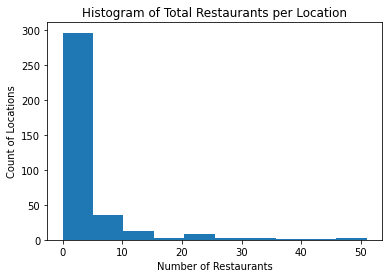

In [22]:
n, bins, patches = plt.hist(df_full_data['Total Restaurants in Area'])
plt.title('Histogram of Total Restaurants per Location')
plt.xlabel('Number of Restaurants')
plt.ylabel('Count of Locations')
plt.show()

Most of these locations have 0 restaurants--let's' filter the dataframe to only look at locations with one or zero restaurnats.

In [23]:
groups = df_full_data.groupby('Total Restaurants in Area')
df0 = groups.get_group(0)
df1 = groups.get_group(1)
df2 = df0.append(df1)
df2.describe()

Latitude   Longitude              X             Y  \
count  208.000000  208.000000     208.000000  2.080000e+02   
mean    32.774569  -96.799315  706121.243255  3.628440e+06   
std      0.022848    0.028757    2697.830376  2.530689e+03   
min     32.736617  -96.850051  701380.858639  3.624256e+06   
25%     32.756344  -96.822568  703880.858639  3.626421e+06   
50%     32.770043  -96.798217  706130.858639  3.627936e+06   
75%     32.792944  -96.775706  708380.858639  3.630426e+06   
max     32.822956  -96.745732  711130.858639  3.633782e+06   

       Distance from Center   WalkScore  Total Restaurants in Area  \
count            208.000000  208.000000                 208.000000   
mean            3598.184857   47.899038                   0.365385   
std             1029.006786   22.919401                   0.482700   
min              535.640894    0.000000                   0.000000   
25%             2771.466604   30.750000                   0.000000   
50%             3873.602462   48.000000                   0.000000   
75%             4420.416868   66.000000                   1.000000   
max             5000.165710   92.000000                   1.000000   

       Distance to Asian Restaurant  Distance to Thai Restaurant  
count                    208.000000                   208.000000  
mean                    1782.288621                  2013.327045  
std                     1074.201329                  1018.772873  
min                       63.830654                   290.633142  
25%                      867.087888                  1176.252071  
50%                     1632.517642                  1948.162752  
75%                     2538.700541                  2796.025847  
max                     4158.844330                  4158.844330

Good--we have 208 candidates left. Let's sort them to see which ones are furthest from other Asian Restaurants.<br>
Then let's plot these on our map of Dallas Neighborhoods.

In [24]:
df2.sort_values(by='Distance to Asian Restaurant', inplace=True, ascending=False)
df2.head()

Latitude  Longitude              X             Y  Distance from Center  \
14   32.740379 -96.778712  708130.858639  3.624689e+06           4806.682589   
13   32.740473 -96.784045  707630.858639  3.624689e+06           4621.060215   
5    32.736617 -96.786808  707380.858639  3.624256e+06           4963.814213   
26   32.744140 -96.770616  708880.858639  3.625122e+06           4803.013999   
131  32.767177 -96.748694  710880.858639  3.627720e+06           4935.323621   

                                         geometry  Neighborhood  WalkScore  \
14   POINT (32.74037869753496 -96.77871207112624)  South Dallas         11   
13   POINT (32.74047313186202 -96.78404489626953)  South Dallas         26   
5    POINT (32.73661708587623 -96.78680784473728)  South Dallas         33   
26   POINT (32.74413975433875 -96.77061563854708)  South Dallas          4   
131  POINT (32.76717673619356 -96.74869439061325)     Fair Park         48   

       Description  Total Restaurants in Area  Distance to Asian Restaurant  \
14   Car-Dependent                          0                   4158.844330   
13   Car-Dependent                          0                   4058.212159   
5    Car-Dependent                          0                   4027.958518   
26   Car-Dependent                          0                   4022.749592   
131  Car-Dependent                          1                   3951.858027   

     Distance to Thai Restaurant  
14                   4158.844330  
13                   4058.212159  
5                    4027.958518  
26                   4022.749592  
131                  3951.858027

In [33]:
map_dallas = folium.Map(location=dallas_center, zoom_start=11)

for comp in competitors.values():
    lat = comp[2]
    lon = comp[3]
    is_thai = comp[7]
    is_asian = comp[6]
    if is_thai:
        color = 'red'
    elif is_asian:
        color = 'purple'
    else:
        color = 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_opacity=1).add_to(map_dallas)

# for lat, lon in zip(latitudes, longitudes):
#     folium.Circle([lat,lon], radius=250, color='purple', fill=False).add_to(map_dallas)
for lat, lon in zip(df2['Latitude'].to_list(), df2['Longitude'].to_list()):
    folium.Circle([lat,lon], radius = 250, color = 'purple', fill=False).add_to(map_dallas)
# folium.GeoJson(geoj, name="geojson", tooltip=t).add_to(map_dallas)
map_dallas

Okay--we've narrowed down our options somewhat.<br>
Let's grade each location on how far it is from the nearest Asian Restaurant, and how close it is to the city center.

In [35]:
def add_bins(df, column_label, bin_count=6):
    min1 = df[column_label].min()
    max1 = df[column_label].max()
    bins = np.linspace(min1, max1, bin_count)
    return pd.cut(df[column_label], bins=bins, include_lowest=True, labels=False)

# We need to reverse the bins for our grade for the Distance from Center.
# We want a higher score for low numbers (close to center) and a lower score for high numbers (far from center)
rev = {0:4, 1:3, 2:2, 3:1, 4:0}
df2['Score1'] = add_bins(df2, 'Distance to Asian Restaurant')
df2['Score2'] = add_bins(df2, 'Distance from Center').map(rev)
df2['Score3'] = add_bins(df2, 'WalkScore')
df2.head()


Latitude  Longitude              X             Y  Distance from Center  \
14   32.740379 -96.778712  708130.858639  3.624689e+06           4806.682589   
13   32.740473 -96.784045  707630.858639  3.624689e+06           4621.060215   
5    32.736617 -96.786808  707380.858639  3.624256e+06           4963.814213   
26   32.744140 -96.770616  708880.858639  3.625122e+06           4803.013999   
131  32.767177 -96.748694  710880.858639  3.627720e+06           4935.323621   

                                         geometry  Neighborhood  WalkScore  \
14   POINT (32.74037869753496 -96.77871207112624)  South Dallas         11   
13   POINT (32.74047313186202 -96.78404489626953)  South Dallas         26   
5    POINT (32.73661708587623 -96.78680784473728)  South Dallas         33   
26   POINT (32.74413975433875 -96.77061563854708)  South Dallas          4   
131  POINT (32.76717673619356 -96.74869439061325)     Fair Park         48   

       Description  Total Restaurants in Area  Distance to Asian Restaurant  \
14   Car-Dependent                          0                   4158.844330   
13   Car-Dependent                          0                   4058.212159   
5    Car-Dependent                          0                   4027.958518   
26   Car-Dependent                          0                   4022.749592   
131  Car-Dependent                          1                   3951.858027   

     Distance to Thai Restaurant  Score1  Score2  Score3  
14                   4158.844330       4       0       0  
13                   4058.212159       4       0       1  
5                    4027.958518       4       0       1  
26                   4022.749592       4       0       0  
131                  3951.858027       4       0       2

Now let's add the scores together.<br>
Restaurants are more dense near the city center, so it's unlikely any location will have a high score in both categories.<br>
A similar relationship exists between the "Walkability Score" and the distance from other restaurants.<br><br>
However, when we combine all three scores, we have an acceptable distribution of combined scores.


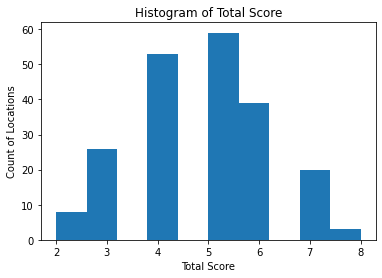

In [36]:
df2['TotalScore'] = df2['Score1'] + df2['Score2'] + df2['Score3']
n, bins, patches = plt.hist(df2['TotalScore'])
plt.title('Histogram of Total Score')
plt.xlabel('Total Score')
plt.ylabel('Count of Locations')
plt.show()

Let's create a color key--assign bright red to the highest score and dark red/gray to the lowest score.<br>

In [40]:
color_key = {
    8: '#F23D3D',
    7: '#BF3030',
    6: '#802020',
    5: '#802020',
    4: '#401010',
    3: '#401010',
    2: '#260A0A',
    1: '#260A0A',
    'err':  '#000000'
}

In [41]:
map_dallas = folium.Map(location=dallas_center, zoom_start=11)

for comp in competitors.values():
    lat = comp[2]
    lon = comp[3]
    is_thai = comp[7]
    is_asian = comp[6]
    if is_thai:
        color = 'red'
    elif is_asian:
        color = 'purple'
    else:
        color = 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_opacity=1).add_to(map_dallas)

for lat, lon, score in zip(df2['Latitude'].to_list(), df2['Longitude'].to_list(), df2['TotalScore'].tolist()):
    try:
        color = color_key[score]
    except:
        color = color_key['err']
    folium.Circle([lat,lon], radius = 250, color=color, fill=True, fill_color=color, fill_opacity=0.75).add_to(map_dallas)
folium.GeoJson(geoj, name="geojson", tooltip=t).add_to(map_dallas)
map_dallas

Looks good, we have identified a list of potential locations for a new Thai restaurant, and can rank them according to the client's priorities.<br>

## Results and Discussion

Our analysis shows that Dallas is a large, complex city with a significant number of restaurants.  However, there are certainly areas with a very high density of restaurants, and other areas with a much lower density of restaurants.  We determined that there were a large number of areas within a 10 km radius of the city center that actually contained 1 or 0 restaurants.<br><br>
We then narrowed our search to those areas with limited competition.  We graded each location on their distance from city center, their distance from the nearest existing Asian Cuisine Restaurant, and their walkability score from WalkScore.com.<br><br>
The result is a list of locations that fit at least two of the client's criteria.  The top 10 or 15 locations in the list are a good launching off point for further investigation.

## Conclusion
This project aimed to analyze the city of Dallas and identify locations of interest for a potential new Thai Food restaurant.  After narrowing the search to locations with limited competition, we can provide the resulting list in order of suitability based on the specific factors of walkability and distance from the city center.  Other factors will need to be considered when stakeholders are determining which area from the list best suits their needs.